In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
from ast import literal_eval
import folium
import time
import warnings
import pickle
import sys

warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../models')
# import modules
import  visualize
from maritime_traffic_network import MaritimeTrafficNetwork

In [3]:
# load network from pickle
model_date = '202204' #"['202204']"
location = 'stavanger'
DP_tol = 10
min_samples = 16
data_size = 'full'
refined = '_refined'

model_name = model_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+data_size+'_UTM'+refined
#model_name = model_date+'_waypoints_DP30_HDBSCAN30_stavanger_full_UTM_mahalanobis'
model_path = '../../models/networks/refined_networks/' + model_name + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_stavanger_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 16,
 'clustering_min_cluster_size': 16,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45,
 'refinement': True,
 'refinement_months': ['202204', '202205'],
 'refinement_n_paths': 26359}

In [9]:
# plot network and basemap
network.prune_graph(5, 'refined')
map = network.map_graph(refined=True, line_weight=2, min_passages=1)  #tromso: center=[69, 19], oslo: center=[59, 10.5]

# add some trajectories
all_trajectories = network.trajectories
selection_start = 0
selection_end = 1 #len(all_trajectories)
selection_step = 1
selection = np.arange(selection_start, selection_end, selection_step)
#selection = [0, 1, 10, 100, 500, 1000, 2999, 5000]
mmsis = network.gdf.mmsi.unique()[selection]
#mmsis = test_gdf.mmsi.unique()[selection]
#mmsis = ['257062150_2_2022-04-19 20:22:52']
#trajectories = all_trajectories.filter('mmsi', mmsis.tolist())
for mmsi in mmsis:
    print(mmsi)
    trajectory = all_trajectories.get_trajectory(mmsi)
    path_df_sspd, evaluation_results_sspd = network.trajectory_to_path_sspd(trajectory, verbose=False)
    print(evaluation_results_sspd[['message', 'SSPD']])
    print('------------------')
    try:
        map = trajectory.to_line_gdf()[['geometry', 'mmsi', 'skipsgruppe']].explore(m=map, style_kwds={'weight':3, 'color':'black', 'opacity':1}, 
                                                                      name=mmsi+' trajectory')
        map = path_df_sspd.explore(m=map, name=mmsi+' edge_sequence sspd', style_kwds={'weight':3, 'color':'cyan', 'opacity':1})
    except:
        print(mmsi+': no path found')

bbox = visualize.get_bounding_box(network.gdf)
map = bbox.explore(m=map, color='red', name='bounds')
folium.LayerControl().add_to(map)
#map

Pruning...
------------------------
Pruned Graph:
Number of nodes: 2241 (20 isolated)
Number of edges: 7634
------------------------
205209000_0_2022-04-08 03:12:48
   message        SSPD
0  success  221.603462
------------------


In [10]:
map.save('../../reports/maps/'+model_name+'.html')
print(f'Map saved under {"../../reports/maps/"+model_name+".html"}')

Map saved under ../../reports/maps/202204_waypoints_DP10_HDBSCAN16_stavanger_full_UTM_refined.html


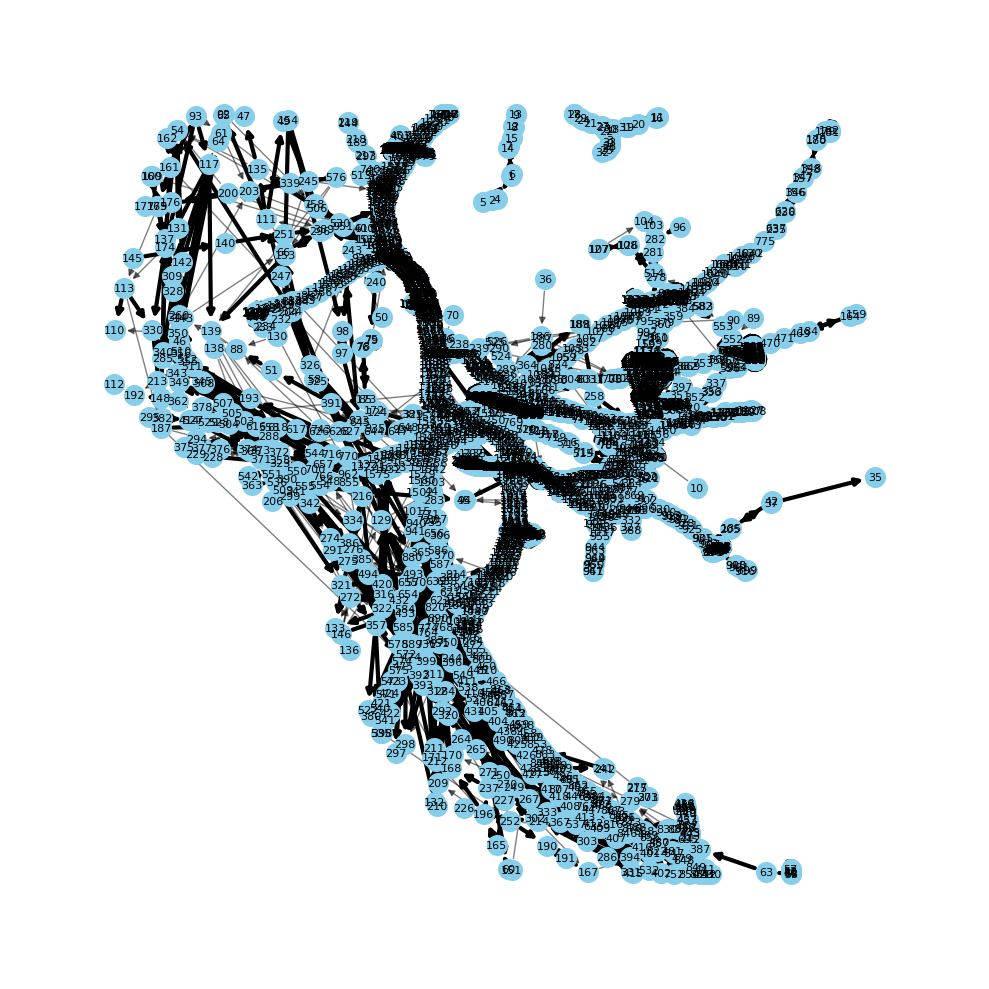

In [6]:
network.plot_graph_canvas(pruned=True)

In [7]:
# Calculate average out-degree
# Calculate out-degrees of all nodes
out_degrees = network.G.out_degree()
average_out_degree = sum(out_degree for node, out_degree in out_degrees) / len(out_degrees)
print("Average Out-Degree:", average_out_degree)

Average Out-Degree: 5.703257474341812


In [8]:
conn = network.waypoint_connections_refined
rows_with_nan = conn[conn.isna().any(axis=1)]
rows_with_nan.head(30)

,from,to,geometry,direction,length,passages,speed_mean,speed_std,speed_95_perc_confidence,speed_distribution,cross_track_dist_mean,cross_track_dist_std,cross_track_dist_skew,cross_track_dist_kurtosis,cross_track_dist_95_perc_confidence,cross_track_dist_distribution
4537,1148,1183,"LINESTRING (287714.619 6613896.299, 288021.674...",37.202313,472.822753,7,NaN,NaN,"[nan, nan]",[],-26.501716,29.084631,-2.720512e+00,8.781396,"[30.504159824652493, -83.50759179654104]","[-50.757567742602824, -9.947401681937102, -10...."
4557,1148,1192,"LINESTRING (287714.619 6613896.299, 288337.672...",43.438388,855.618852,2,NaN,NaN,"[nan, nan]",[],-24.368466,31.389368,-3.297854e+00,10.690882,"[37.1546958717209, -85.89162841444949]","[3.832197964266669, -1.7519879746728892, -5.48..."
4559,1148,1190,"LINESTRING (287714.619 6613896.299, 288123.746...",39.509915,602.088315,6,NaN,NaN,"[nan, nan]",[],-38.995022,60.974884,-1.426089e+00,3.660914,"[80.51575025391752, -158.50579335070597]","[-71.27116926188619, -24.588926717091617, -22...."
4569,1152,1190,"LINESTRING (287822.571 6614053.144, 288123.746...",43.297147,414.567702,9,NaN,NaN,"[nan, nan]",[],-19.282807,56.682900,-1.618684e+00,6.310772,"[91.81567714738681, -130.3812907952962]","[-73.48727481840125, -17.347717229103125, -18...."
4573,806,844,"LINESTRING (288880.201 6614639.829, 287995.419...",242.014658,973.996851,2,NaN,NaN,"[nan, nan]",[],8.169008,19.922298,1.186786e+00,2.270114,"[47.216712353034076, -30.878696411995328]","[-23.1264223956263, -3.5963614912681265, -1.77..."
5304,1899,1985,"LINESTRING (297427.995 6564486.615, 297484.553...",28.144438,109.080805,3,NaN,NaN,"[nan, nan]",[],4.653154,24.857293,-8.620860e-01,2.329978,"[53.37344701838924, -44.067139744776426]","[20.53579107671984, 17.656082192751093, 14.776..."
5615,1792,2146,"LINESTRING (297752.971 6564543.750, 297701.733...",236.032480,59.700742,1,NaN,NaN,"[nan, nan]",[],-7.877928,6.675506,-3.483167e-11,-1.224242,"[5.206063140640041, -20.961918778890617]","[2.580579472200135, 0.25646674085557647, -2.06..."
5624,1792,2150,"LINESTRING (297752.971 6564543.750, 297669.294...",249.790487,87.564604,1,NaN,NaN,"[nan, nan]",[],-0.415752,8.470714,3.225257e-01,-0.791872,"[16.186847355002282, -17.018352280389042]","[15.850953940290456, 8.421816682051745, 5.7384..."
8956,591,557,"LINESTRING (335221.408 6571489.780, 337684.772...",70.464723,2576.202533,1,NaN,NaN,"[nan, nan]",[],148.593118,305.396582,-4.327678e-01,0.230648,"[747.1704180120346, -449.9841814950921]","[686.5448437172433, 410.2253880949684, 329.806..."
9474,1521,909,"LINESTRING (304835.903 6560464.657, 304987.010...",18.420841,414.484193,1,NaN,NaN,"[nan, nan]",[],59.868055,60.428201,-2.043542e-12,-1.224242,"[178.30732853684998, -58.57121937404379]","[-34.80474166826761, -13.766342501802377, 7.27..."
